<a href="https://colab.research.google.com/github/calibretaliation/DeepLearning20211/blob/main/siamese_net_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/calibretaliation/DeepLearning20211.git

Cloning into 'DeepLearning20211'...
remote: Enumerating objects: 32478, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 32478 (delta 5), reused 0 (delta 0), pack-reused 32466
Receiving objects: 100% (32478/32478), 1.68 GiB | 26.49 MiB/s, done.
Resolving deltas: 100% (63/63), done.
Checking out files: 100% (32428/32428), done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import os

import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications, layers, losses, optimizers, metrics, Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD



from pathlib import Path
from tensorflow.keras import applications, layers, losses, optimizers, metrics, Model
from tensorflow.keras.applications import resnet

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [47]:
train_df = pd.read_csv('DeepLearning20211/data/train.csv', index_col=False)
test_df = pd.read_csv('DeepLearning20211/data/test.csv', index_col=False)

train_img_dir = Path('DeepLearning20211/data/train_images')
test_img_dir = Path('DeepLearning20211/data/test_images/')

In [50]:
#@title Drop images with duplicated p-hash value

train_df = train_df.drop_duplicates(subset=['image_phash'])

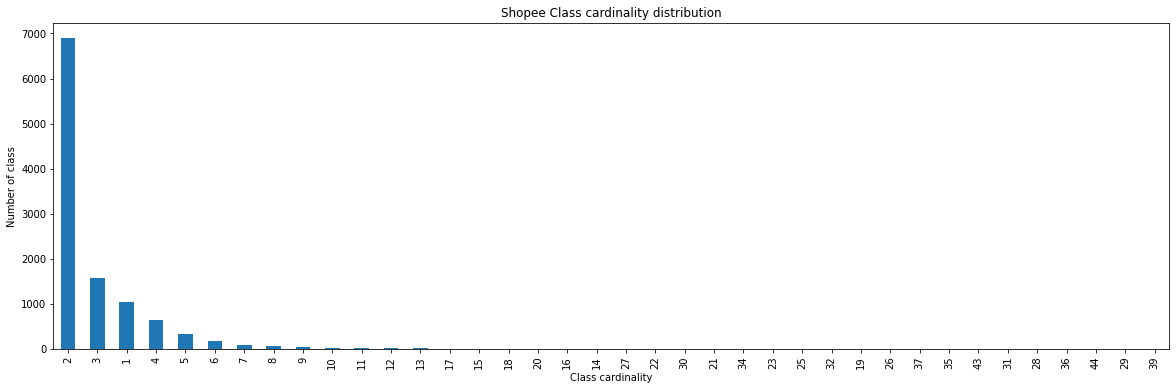

In [37]:
#@title Plot class cardinality distribution

# calculate number of images in each class
label_count = train_df['label_group'].value_counts()

plt.figure(figsize=(20, 6))
label_count.value_counts().plot.bar()
plt.xlabel('Class cardinality')
plt.ylabel('Number of class')
plt.title('Shopee Class cardinality distribution')
plt.show()

In [59]:
label_count[249114794]

2

In [ ]:
for i in range(len(train_df)):
    # ten file: train_df.iloc[i]['image']
    # label_count[train_df.iloc[i]['label_group']]

In [57]:
train_df.iloc[0]['image']

'0000a68812bc7e98c42888dfb1c07da0.jpg'

In [58]:
train_df.head(5)

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [ ]:
#@title Augmentation sao cho tất cả các class đều có 39 ảnh

data_augmentation = tf.keras.Sequential(
    [
     tf.keras.layers.RandomFlip("horizontal_and_vertical"),
     tf.keras.layers.RandomRotation(0.05),
     tf.keras.layers.RandomContrast(0.5),
     tf.keras.layers.RandomZoom(0.1, 0.1),
     tf.keras.layers.RandomTranslation(0.14, 0.14)
     ]
)

1 4 7
2 5 8
3 6 9
